# Svensson (1994)



$$ r(t) = \beta_1 + \beta_2\frac{1-e^{-\lambda_1 t}}{\lambda_1 t} 
        + \beta_3 \left(\frac{1-e^{-\lambda_1 t}}{\lambda_1 t}-e^{-\lambda_1 t}\right)
        + \beta_4 \left(\frac{1-e^{-\lambda_2 t}}{\lambda_2 t}-e^{-\lambda_2 t}\right)$$

### Importing the data

In [66]:
from scipy.optimize import fmin
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from workadays import workdays as wd

path = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Base_LTN.xlsx"
path2 = r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Brasil\ETTJ\Parametros.xlsx"
df = pd.read_excel(path)
parameters = pd.read_excel(path2)

In [67]:
parameters.set_index("Data referência", inplace=True)
df["Maturity"] = df.apply(lambda row: wd.networkdays(row["DATA_REFERENCIA"], row["DATA_VENCIMENTO"]), axis=1)/252
df.set_index("DATA_REFERENCIA", inplace=True)

In [68]:
df.head()

,CODIGO,DATA_VENCIMENTO,EXPECTATIVA,PU,Maturity
DATA_REFERENCIA,,,,,
2023-07-03,LTN,2023-10-01,13.2025,968.996662,0.250000
2023-07-03,LTN,2024-01-01,12.7468,942.225059,0.492063
2023-07-03,LTN,2024-04-01,12.1642,918.761537,0.738095
2023-07-03,LTN,2024-07-01,11.5298,897.786879,0.988095
2023-07-03,LTN,2024-10-01,11.0232,877.471104,1.250000


### Generating individuals

In [69]:
N =1200    ### Number of individuals 
p = int(2/3*N)      ## Proportion of individuals generated by method 1
var = 0.5

### 1 - Initial Values of the results of the estimation of the previous day

ref_date_str = "2023-07-27"
ref_date = datetime.strptime(ref_date_str, "%Y-%m-%d")
previous_date = ref_date - timedelta(days=1)
previous_parameters = parameters.loc[previous_date][1:]
beta_star_1 = np.array([previous_parameters.replace(previous_parameters[1],previous_parameters[0])])
e_previous = beta_star_1.T*np.random.normal(0, var, size=(6, p))
beta_previous = beta_star_1.T + e_previous

### 2 - Approximation that takes into account the observed yield to maturity (ytm)

data_estimada = df.loc[ref_date_str]
data_estimada.sort_values("Maturity")
b1 = data_estimada["EXPECTATIVA"][0]/100
b2 = data_estimada["EXPECTATIVA"][-1]/100 - data_estimada["EXPECTATIVA"][0]/100
b3 = 0
b4 = 0
lbda1 = previous_parameters[4]
lbda2 = previous_parameters[5]
#lbda1 = (data_estimada["Maturity"][-1]-data_estimada["Maturity"][0])/2
#lbda2 = lbda1
beta_star_2 = np.array([b1, b2, b3 , b4, lbda1, lbda2])[:, np.newaxis]
e_approx = beta_star_2*np.random.normal(0, var, size=(6, N-p))
beta_approx = beta_star_2 + e_approx ## ajustar colunas

### Adding constraints to the parameters

def update (betas,beta_star):
    updated_value = []
    for index, parameter in enumerate(betas):
        if parameter[0]<0:
            betas[index][0] = beta_star[0]+ beta_star[0]*np.random.normal(0, var)
            updated_value.append(betas[index][0]<0)
        if (parameter[0]+parameter[1])<0:
            betas[index][1] = beta_star[1]+ beta_star[1]*np.random.normal(0, var)
            updated_value.append((betas[index][0]+betas[index][1])<0)
        if parameter[4]<0:
            betas[index][4] = beta_star[4]+ beta_star[4]*np.random.normal(0, var)
            updated_value.append(betas[index][4]<0)
        if parameter[5]<0:
            betas[index][5] = beta_star[5]+ beta_star[5]*np.random.normal(0, var)
            updated_value.append(betas[index][5]<0)
    if sum(updated_value) != 0:
        update(betas,beta_star)
    return(beta_previous.T)

update(beta_previous.T,beta_star_1.T)
update(beta_approx,beta_star_2)

individuals = np.concatenate((beta_previous.T, beta_approx.T), axis=0)

In [70]:
beta_previous[:,0]

array([0.16450793, 0.24620467, 0.07304162, 0.01878355, 2.87858206,
       1.77031131])

In [71]:
beta_approx[:,0]

array([0.34533393, 0.09219015, 0.        , 0.        , 5.23196605,
       1.72378807])

### Selection

In [72]:
### add duration and coupons
values = []

### 40% of the individuals survive
s = int(0.4 * N)

for row in individuals:
    def myval(c):
        df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))+(c[2]*((((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))-(np.exp(-df['Maturity']*c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']*c[5]))/(df['Maturity']*c[5])))-(np.exp(-df['Maturity']*c[5]))))
        df['Calculated_price'] = 1000 / (1 + df['NSS']) ** df['Maturity'] 
        df['Residual'] =  ((df['PU'] - df['Calculated_price'])**2)*(1/df["Maturity"]**0.5)
        val = np.sum(df['Residual'])
        return(val)
    
    val = myval(row)
    values.append((val, row)) 
sol = pd.DataFrame(values, columns=['SC', "Parameters"]).sort_values('SC')

selection = sol.sort_values('SC')[0:s]

In [73]:
selection.head()

,SC,Parameters
670,1940.470007,"[0.1178383764175101, 0.004464826525546833, 0.1..."
786,2206.526192,"[0.11932839858900385, 0.04625981796936679, 0.0..."
633,2527.304686,"[0.09406949006146283, 0.0845019427299448, 0.05..."
550,2903.889800,"[0.09982940908139615, 0.05100347360843989, 0.0..."
246,3621.913493,"[0.11781421407584519, 0.06870607059552182, 0.0..."


### Cross-Over

In [74]:
alpha = 6
next_gen = []


for num in range(N):
    psi = np.random.uniform(0, 1)
    theta_r = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
    theta_s = np.concatenate(selection.iloc[(np.random.beta(1,alpha, 1)*s),:]["Parameters"].values)
    next_gen.append(psi*theta_r+(1-psi)*theta_s)



### Mutation

In [75]:
pi = 0.35
var = 0.5 ## ajustar a var para a geracao maior que 2
e_mutation = []

for num in range(N):
    e = np.random.normal(0, var, 6)*np.random.choice([0, 1], size=6, p=[1 - pi, pi])
    e_mutation.append(e)

new_individuals = np.array(next_gen) + np.array(next_gen)*np.array(e_mutation)

## add constraints to the parameters


In [76]:
new_individuals

array([[ 4.58051164e-02, -2.88978532e-03,  4.07227638e-02,
        -1.16460599e-01,  2.60688135e+00,  1.24029906e+00],
       [ 1.31873072e-01, -1.12089460e-02,  8.21215909e-03,
        -2.56663790e-02,  3.47515777e+00,  2.08424471e+00],
       [ 1.79774310e-01,  1.05297344e-02,  1.48310437e-02,
        -3.64441905e-02,  3.93758126e+00,  2.28576736e+00],
       ...,
       [ 9.27264701e-02,  1.28085614e-02,  1.83924878e-02,
        -4.12739599e-03,  6.11147304e+00,  1.04494714e+00],
       [ 1.07444956e-01,  5.70146018e-02,  3.91092556e-02,
        -1.14174763e-01,  2.07383423e+00,  1.21040203e+00],
       [ 8.49887235e-02,  1.59504174e-01,  1.57406592e-01,
        -8.10270612e-02,  3.44932300e+00,  1.24442947e+00]])

In [77]:
for row in new_individuals:
    def myval(c):
        df['NSS'] =(c[0])+(c[1]*((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))+(c[2]*((((1-np.exp(-df['Maturity']*c[4]))/(df['Maturity']*c[4])))-(np.exp(-df['Maturity']*c[4]))))+(c[3]*((((1-np.exp(-df['Maturity']*c[5]))/(df['Maturity']*c[5])))-(np.exp(-df['Maturity']*c[5]))))
        df['Calculated_price'] = 1000 / (1 + df['NSS']) ** df['Maturity'] 
        df['Residual'] =  (df['PU'] - df['Calculated_price'])**2*(1/df["Maturity"]**0.5)
        val = np.sum(df['Residual'])
        return(val) 
    val = myval(row)
    values.append((val, row)) 
sol_2 = pd.DataFrame(values, columns=['SC', "Parameters"]).sort_values('SC')

selection = sol_2[0:s]

In [78]:
selection

,SC,Parameters
1417,597.150472,"[0.12645402402460937, 0.016089854934346687, 0...."
1696,761.831663,"[0.11761000407259953, 0.009545511450349858, 0...."
2068,874.010995,"[0.1158061186503895, 0.04844136906201553, 0.02..."
1887,1051.203719,"[0.11635540356277857, 0.024508500298977352, 0...."
1706,1191.723022,"[0.10697958931643574, 0.0445254520174589, 0.10..."
...,...,...
1156,27676.613064,"[0.10147862925558579, -0.016699383769572154, 0..."
1614,27724.391688,"[0.09770013641535709, 0.08885689850630311, 0.0..."
347,27862.543614,"[0.08379120033928623, 0.1027912474743164, 0.07..."
1814,27864.328210,"[0.11577235666784574, -0.01305851811987353, 0...."


In [79]:
dia27 = selection.iloc[0][1]

In [80]:
dia27_anbima = parameters.iloc[-2,1:].values


In [81]:
dia27_anbima

array([0.114358254774121, 0.018715794279205, 0.0679754297455865,
       -0.0961284649369684, 2.70022735771407, 1.22958147196742],
      dtype=object)

Text(0.5, 1.0, '27/08')

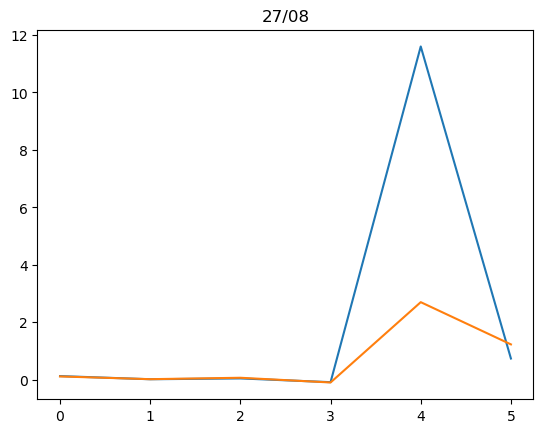

In [82]:
plt.plot(dia27)
plt.plot(dia27_anbima)
plt.title('27/08')